# NLP Model

- Create a basic nlp model to predict bin price
- Create a basic model using car info to predict bin price

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import re
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import xgboost as xgb

In [2]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [3]:
from tqdm.notebook import tqdm

In [4]:
data = pd.read_csv('CleanData3bins.csv')

In [5]:
data = data.drop(columns='Unnamed: 0')

# Features for the car

In [6]:
data.head()

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0


In [7]:
rev_index = 89

In [8]:
sentence = data['CleanReviews'][rev_index]
sentence

'I like the Highlander XLE but every time I’m on the highway driving I can hear the wind on the driver side. Toyota has not been able to fix it or figure out how to fix it. And while waiting at the light sometimes it feels like the highlander just stopped running and when push the gas paddle it sounds like you just started the engine. I’m a little disappointed. Hate there’s no CD player. Even Lexus has a CD player. , Purchased 2021 Limited in August and have been very pleased with the safety features, especially the front and rear sensors.  I hear 2022 trim levels XLE and higher have the passenger power height adjustment, finally!  This the biggest issue I have with my Highlander.  I also think the front seats could be a little longer to support legs better!  They used to have this in the 2nd generation.  Otherwise I like my vehicle a lot.  7,800 miles so far!, I got my 21 Highlander last year... It was my Birthday gift from my husband...I had always wanted one... He said lets go look 

In [9]:
blob_object = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
# Running sentiment analysis
analysis = blob_object.sentiment
print(analysis)
print(analysis[0])

Sentiment(classification='pos', p_pos=0.9999804897500271, p_neg=1.9510249965100588e-05)
pos


In [13]:
sentiment = []

In [14]:
for rev in tqdm(data['CleanReviews']):
    blob = TextBlob(rev)
    sent = blob.polarity
    sentiment.append(sent)

In [16]:
data['sentiment'] = sentiment

In [17]:
data.head()

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg,sentiment
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0,0.129915
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0,0.163393
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0,0.223107
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0,0.190580
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0,0.106792


In [18]:
# bins = [
#     (data['sentiment'] <0),
#     (data['SalePrice'] >0)
#     ]

# # create a list of the values we want to assign for each condition
# price_cat = ['neg', 'pos']

# # create a new column and use np.select to assign values to it using our lists as arguments
# data['sentiment'] = np.select(bins, price_cat)

In [19]:
X = data.drop(columns=['CleanReviews', 'PriceCategory', 'SalePrice'])
y = data['PriceCategory']

In [20]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

In [22]:
num_cols = ['Mileage', 'Year', 'newSize', 'newCyl', 'mpg', 'sentiment']
cat_cols = ['DriveTrain', 'newMake']

In [23]:
cat_transformer = OneHotEncoder(drop=['RWD', 'Other'])

In [24]:
num_transformer = MinMaxScaler()

In [25]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", num_transformer, num_cols),
    ('cat_trans', cat_transformer, cat_cols)
])

In [26]:
preprocessor.fit_transform(X_train)

<5719x33 sparse matrix of type '<class 'numpy.float64'>'
	with 44505 stored elements in Compressed Sparse Row format>

# Knn

In [27]:
clf_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [28]:
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('knn', KNeighborsClassifier())])

In [29]:
print(f"Train Accuracy: {clf_knn.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_knn.score(X_val, y_val)}")

Train Accuracy: 0.7466340269277846
Test Accuracy: 0.6224436287362349


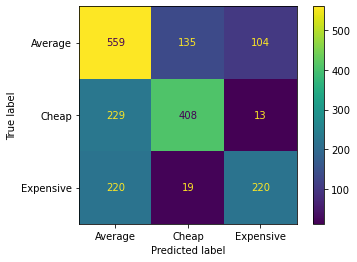

In [30]:
plot_confusion_matrix(clf_knn, X_val, y_val);

# Decision Tree

In [31]:
clf_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [32]:
clf_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [33]:
print(f"Train Accuracy: {clf_dt.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_dt.score(X_val, y_val)}")

Train Accuracy: 1.0
Test Accuracy: 0.6560041950707918


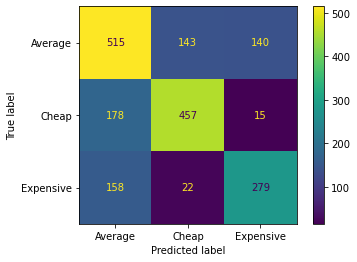

In [34]:
plot_confusion_matrix(clf_dt, X_val, y_val);

# LogReg

In [35]:
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', random_state=42))
])

In [36]:
clf_lr.fit(X_train, y_train)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('lr',
                 LogisticRegression(multi_class='multinomial', penalty='l1',
                                    random_state=42, solver='saga'))])

In [37]:
print(f"Train Accuracy: {clf_lr.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_lr.score(X_val, y_val)}")

Train Accuracy: 0.6927784577723378
Test Accuracy: 0.670162558993183


In [38]:
cv_results = cross_validate(clf_lr, X_train, y_train, cv=5, return_train_score=True)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

In [39]:
cv_results['test_score'].mean()

0.6814123977509803

In [40]:
cv_results['train_score'].mean()

0.6928222801788376

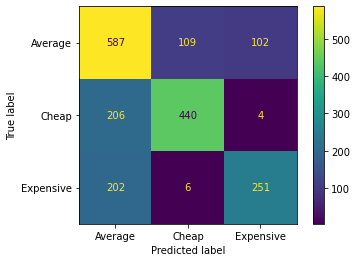

In [41]:
plot_confusion_matrix(clf_lr, X_val, y_val);

# Random Forest

In [42]:
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(max_depth=10, random_state=42))
])

In [43]:
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [44]:
print(f"Train Accuracy: {clf_rf.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_rf.score(X_val, y_val)}")

Train Accuracy: 0.8073089700996677
Test Accuracy: 0.7178814892501311


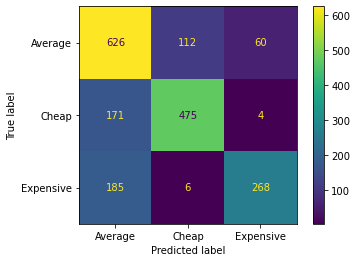

In [45]:
plot_confusion_matrix(clf_rf, X_val, y_val);

# Ridge classifier

In [46]:
clf_rr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rr', RidgeClassifier(solver='sag', random_state=42))
])

In [47]:
clf_rr.fit(X_train, y_train)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('rr', RidgeClassifier(random_state=42, solver='sag'))])

In [48]:
print(f"Train Accuracy: {clf_rr.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_rr.score(X_val, y_val)}")

Train Accuracy: 0.6548347613219094
Test Accuracy: 0.6371263765076036


In [49]:
cv_results_rr = cross_validate(clf_rr, X_train, y_train, cv=5, return_train_score=True)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warning

In [50]:
cv_results_rr['test_score'].mean()

0.6446914633922508

In [51]:
cv_results_rr['train_score'].mean()

0.6568892964958538

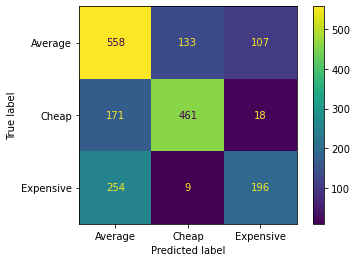

In [52]:
plot_confusion_matrix(clf_rr, X_val, y_val);

# XGBoost

In [53]:
clf_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(random_state=42, 
                              learning_rate=.1, 
                              max_depth=6,
                             n_estimators=50))
])

In [54]:
clf_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg',
                                                   'sentiment']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
         

In [55]:
print(f"Train Accuracy: {clf_xgb.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_xgb.score(X_val, y_val)}")

Train Accuracy: 0.8150026228361602
Test Accuracy: 0.7519664394336655


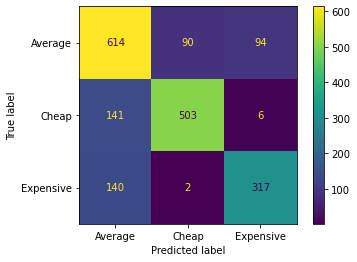

In [56]:
plot_confusion_matrix(clf_xgb, X_val, y_val);

In [57]:
y_val.value_counts()

Average      798
Cheap        650
Expensive    459
Name: PriceCategory, dtype: int64